# Load data, filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List

In [2]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (m, n) and a column 
    vector with the m class labels in {0, ..., 9}
    """
    df =np.loadtxt(path,delimiter=',')
    X=df[:,1:]
    y=df[:,0:1]
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (X.shape[0], 1), 'Same number of lines is required'
    return X, y

In [3]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [4]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (60000, 784)
assert y_train.shape == (60000, 1)

X_test, y_test = load_file(path_test)
assert X_test.shape == (10000, 784)
assert y_test.shape == (10000, 1)

In [5]:

def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    result = X/255
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [6]:
X_train = scale_values(X_train)
assert X_train.shape == (60000, 784)
X_test = scale_values(X_test)
assert X_test.shape == (10000, 784)


In [7]:
def augment_matrix(X: np.ndarray) -> np.ndarray:
    """Creates the design matrix: the original matrix with a prepended column 
    of 1.
    :param X: an (m, n) matrix. Each row contains the pixels of a digit.
    :return: an ndarray of shape (X.shape[0], X.shape[1]+1)
    """
    m = X.shape[0]
    result =np.insert(X,0,1,axis=1)
    assert result.shape == (X.shape[0], X.shape[1] + 1)
    assert np.alltrue(result[:, 0] == 1), 'The first column should be filled with 1'
    return result

In [8]:
X_train = augment_matrix(X_train)
X_test = augment_matrix(X_test)

# Create model

In [9]:
k = 10 # number of classes
m, n = X_train.shape # after augmentation

In [10]:
def softmax(z, axis=1):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    :return: np.array of shape (m, k) containing in cell (i, j): P(class=j|input i)
    """
    max_z = np.max(z, axis=axis, keepdims=True)
    exp_z =np.exp(z-max_z)
    sum_exp_z =np.sum(exp_z,axis=1).reshape((-1,1))
    result = exp_z/sum_exp_z
    assert exp_z.shape == z.shape
    assert np.allclose(np.sum(result, axis=1), 1)
    return result

In [11]:
def can_multiply(a, b):
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

In [12]:
def model(X, theta):
    """
    :param X: np.array of shape (m, n)
    :param theta: np.array of shape (n, k)
    :return: np.array of shape (m, k) containing in cell (i, j): P(class=j|input i)
    """
    assert can_multiply(X, theta)
    result=softmax(np.dot(X,theta))
    return result

In [13]:
def J(X, y, num_classes, theta, _lambda):
    """Computes the error function for multinomial logisitc regression
    :param X: np.array of shape (m, n)
    :param y: np.array of shape (m, 1)
    :param theta: np.array of shape (n, k) 
    :return: loss values, ocmposed of cross entropy + penalty term
    """
    m = X.shape[0]
    EPS = 1e-6
    # computes a one hot encoding for the griven classes:
    # if y[i]=c, 0 <= c <= 9 (here), then line i in one_hot_encoding is filled
    # in with 0, excepting column c where one can find value 1
    j=np.arange(m)
    one_hot_encoding = np.zeros((m, num_classes))
#     one_hot_encoding[j,y[j,0].astype(int)]=1
    one_hot_encoding[np.arange(m),y[np.arange(m),0].astype(int)]=1

    assert np.all(one_hot_encoding.sum(axis=1) == 1)
    predicted = model(X,theta)
    predicted = np.clip(predicted, EPS, 1-EPS) # se evita valori care duc la log(0)
    log_predicted = np.log(predicted)
    temp = one_hot_encoding*log_predicted
    loss1 = -temp.sum() / m # calcul valoare medie a erorii
    loss2 = (_lambda/(2*m))*np.sum((theta[1:,:]*theta[1:,:]))
    return loss1 + loss2

In [14]:
def gradient(X, theta, y, num_classes, _lambda):
    """
    :param X: np.array of shape (m, n)
    :param theta: np.array of shape (n, k)
    :param y: np.array of shape (m, 1)
    :return: np.array of shape (n, k)
    """
    
    m, n = X.shape
    j=np.arange(m)
    one_hot_encoding = np.zeros((m, num_classes))
    one_hot_encoding[j,y[j,0].astype(int)]=1
    predicted = model(X,theta)
    grad =np.dot(np.transpose(X),one_hot_encoding-predicted)/(-m)
    grad[1:,:]+=((_lambda/m)*theta)[1:,:]
    
    return grad

In [15]:
def accuracy(X:np.array, y:np.array, theta:np.array) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (m, n)
    :param y: np.array of shape (m, 1); each value is the index of a class
    :param theta: np.array of shape (n, k) with weights
    :return: ratio between correcly classified cases and total number of classes
    """
    y_hat = model(X,theta)
    y_predicted = np.reshape(np.argmax(y_hat,axis=1),y.shape)
    return (y_predicted == y).sum() / X.shape[0]

In [16]:
y_train.shape
# np.argmax(model(X_train,theta),axis=1)
# np.reshape(np.argmax(model(X_train,theta),axis=1),y_train.shape[-1])

(60000, 1)

# Train model

In [17]:

def train(X: np.array, y: np.array, num_classes, theta_init: np.array, _lambda: float, alpha: float, max_delta_error:float=1e-4) -> Tuple[np.array, List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when  
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X: np.array of shape (m, n), with training cases. Each row is a traininv case
    :param y: np.array of shape (m, 1), containing labels (0=class 0, ...)
    :param theta_init: np.array of shape (n, k), initial weights
    :param _lambda: coefficient >= for the L2 penalty term
    :param num_classes: number of classes
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: weight matrix, list of errors computed at each epoch, 2 lists of accuracies on training and on test set at each epoch
    """
    theta = theta_init
    errors = [J(X, y, num_classes, theta, _lambda)]
    acc_train = [accuracy(X_train, y_train, theta)]
    acc_test = [accuracy(X_test, y_test, theta)]
    epoch = 0
    while True:
        epoch += 1
        theta += -alpha * gradient(X=X, theta=theta, y=y, num_classes=num_classes, _lambda = _lambda)
        error = J(X, y, num_classes, theta, _lambda)
        errors.append(error)
        train_acc = accuracy(X_train, y_train, theta)
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, theta)
        acc_test.append(test_acc)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, error: {error}, accuracy_train: {train_acc}, accuracy_test: {test_acc}')
        if  np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
    return theta, errors

In [18]:
theta = np.zeros((n, k))


theta, errors= train(X=X_train, y=y_train, num_classes = 10, theta_init=theta, _lambda=0.0, alpha=0.5)

Epoch: 10, error: 0.7814931363584073, accuracy_train: 0.8392666666666667, accuracy_test: 0.8471
Epoch: 20, error: 0.6021322470229893, accuracy_train: 0.8612833333333333, accuracy_test: 0.8704
Epoch: 30, error: 0.5287938215016824, accuracy_train: 0.8706833333333334, accuracy_test: 0.8795
Epoch: 40, error: 0.4869374124042889, accuracy_train: 0.8771166666666667, accuracy_test: 0.8857
Epoch: 50, error: 0.4591632140260326, accuracy_train: 0.8817833333333334, accuracy_test: 0.8894
Epoch: 60, error: 0.43904763877793446, accuracy_train: 0.8855333333333333, accuracy_test: 0.8932
Epoch: 70, error: 0.42362129525676784, accuracy_train: 0.8885333333333333, accuracy_test: 0.895
Epoch: 80, error: 0.4113049545049235, accuracy_train: 0.8907, accuracy_test: 0.8988
Epoch: 90, error: 0.401173617933741, accuracy_train: 0.8928166666666667, accuracy_test: 0.8996
Epoch: 100, error: 0.39264577899302106, accuracy_train: 0.8946166666666666, accuracy_test: 0.9012
Epoch: 110, error: 0.38533552559542106, accuracy_t

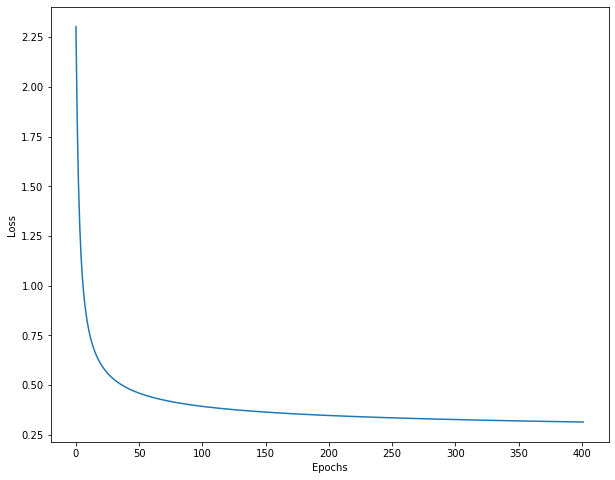

In [55]:
plt.figure(figsize=(10, 8))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Test model

In [56]:
theta2, errors2= train(X=X_test, y=y_test, num_classes = 10, theta_init=theta, _lambda=0.0, alpha=0.5,max_delta_error=1e-4)

Epoch: 10, error: 0.2962503672947223, accuracy_train: 0.9125333333333333, accuracy_test: 0.918
Epoch: 20, error: 0.2918316425209, accuracy_train: 0.9123166666666667, accuracy_test: 0.9192
Epoch: 30, error: 0.288178391133074, accuracy_train: 0.91225, accuracy_test: 0.9201
Epoch: 40, error: 0.2850314041916261, accuracy_train: 0.9122333333333333, accuracy_test: 0.9212
Epoch: 50, error: 0.2822453416744366, accuracy_train: 0.912, accuracy_test: 0.9218
Epoch: 60, error: 0.2797304777615594, accuracy_train: 0.91165, accuracy_test: 0.9222
Epoch: 70, error: 0.2774280142212058, accuracy_train: 0.9116666666666666, accuracy_test: 0.9233
Epoch: 80, error: 0.2752974251958669, accuracy_train: 0.9115833333333333, accuracy_test: 0.9239
Epoch: 90, error: 0.273309561805221, accuracy_train: 0.91155, accuracy_test: 0.9244
Epoch: 100, error: 0.27144269624378053, accuracy_train: 0.9114833333333333, accuracy_test: 0.9248
Epoch: 110, error: 0.26968014203109353, accuracy_train: 0.9115833333333333, accuracy_test:

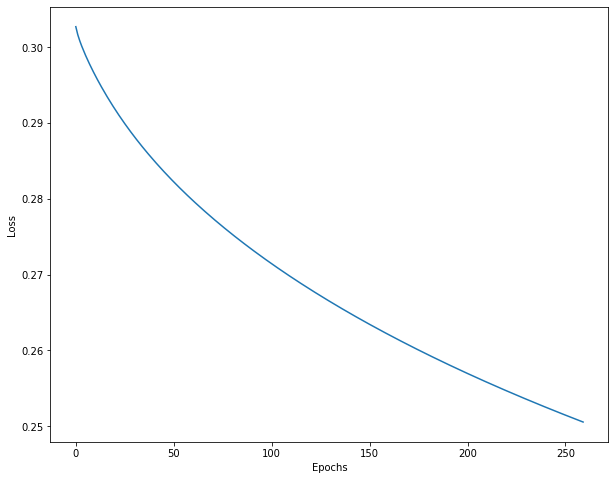

In [57]:
plt.figure(figsize=(10, 8))
plt.plot(errors2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()